In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [26]:
!nvidia-smi

Tue Oct 13 06:26:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:37:00.0 Off |                  Off |
| 29%   38C    P2    26W / 250W |   2843MiB / 32508MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

bur_vol_loss        0.458476
loss                0.035974
spin_loss           0.012932
val_bur_vol_loss    0.507996
val_loss            0.046740
val_spin_loss       0.020495
dtype: float64


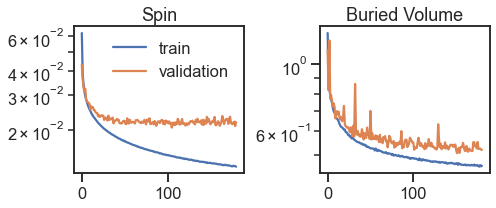

In [34]:
fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(7, 3))

log2 = pd.read_csv('20201012_spin_bv/log.csv', error_bad_lines=False).set_index('epoch')

axs[0].plot(log2['spin_loss'], label='train')
axs[0].plot(log2['val_spin_loss'], label='validation')

axs[0].set_title('Spin')

axs[1].plot(log2['bur_vol_loss'])
axs[1].plot(log2['val_bur_vol_loss'])

axs[1].set_title('Buried Volume')

for ax in axs:
    ax.set_yscale('log')
    
axs[0].legend()

print(log2.min())


plt.tight_layout()
# plt.xlim([0, 10])

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [15]:
from preprocess_inputs_noh import preprocessor
preprocessor.from_json('tfrecords_noh/preprocessor.json')

from loss import AtomInfMask, KLWithLogits
from nfp import EdgeUpdate, NodeUpdate, GlobalUpdate
import tensorflow_addons as tfa

model = tf.keras.models.load_model(
    '20200925_stability_noh/best_model.hdf5',
    custom_objects={**nfp.custom_objects,
                    **{'AtomInfMask': AtomInfMask, 'KLWithLogits': KLWithLogits}})

In [16]:
cdf_spin = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/cdf_spins.csv.gz')
cdf_bv = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/cdf_buried_volume.csv.gz', index_col=0)
cdf = cdf_spin.merge(cdf_bv, on=['smiles', 'atom_index'], how='left')

test = np.load('split.npz', allow_pickle=True)['test']

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [17]:
cdf_test = cdf[cdf.smiles.isin(test)].copy()
cdf_test['fractional_spin'] = cdf_test.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())

In [18]:
redf_spin = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/redf_spins.csv.gz')
redf_bv = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/redf_buried_volume.csv.gz')
redf = redf_spin.merge(redf_bv, on=['smiles', 'atom_index', 'atom_type'], how='left')
redf['fractional_spin'] = redf.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())

redf_test = np.load('redf_split.npz', allow_pickle=True)['test']
redf_smiles = redf.smiles.unique()

In [19]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in test),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_atoms=cdf_test.atom_index.max() + 1),
                  padding_values=preprocessor.padding_values)

In [20]:
redf_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in redf.smiles.unique()),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_atoms=redf.atom_index.max() + 1),
                  padding_values=preprocessor.padding_values)

In [21]:
predicted_spin_logits, predicted_bur_vol = model.predict(test_dataset, verbose=1)
predicted_fractional_spins = tf.nn.softmax(predicted_spin_logits)

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['n_bond', 'bond_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


     17/Unknown - 1s 77ms/step

RDKit WARNING: [17:50:52] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [17:50:52]   BondStereo set to STEREONONE and single bond directions set to NONE.


40/40 [==============================] - 3s 77ms/step


Text(0.5, 1.0, 'Buried Volume')

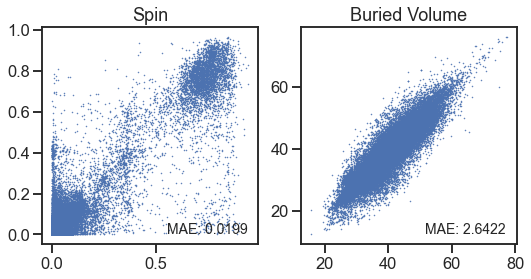

In [22]:
cdf_test_pivot_spins = cdf_test.pivot(index='smiles', columns='atom_index', values='fractional_spin')
cdf_test_pivot_spins = cdf_test_pivot_spins.reindex(test)

cdf_test_pivot_bur_vol = cdf_test.pivot(index='smiles', columns='atom_index', values='buried_vol')
cdf_test_pivot_bur_vol = cdf_test_pivot_bur_vol.reindex(test)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5,4))
axs[0].plot(cdf_test_pivot_spins.values.flatten(), predicted_fractional_spins.numpy().flatten(), '.', ms=1)
axs[0].text(.95, .05, f'MAE: {pd.Series(cdf_test_pivot_spins.values.flatten() - predicted_fractional_spins.numpy().flatten()).dropna().abs().mean():.4f}', ha='right',
            transform=axs[0].transAxes, fontsize=14)

axs[1].plot(cdf_test_pivot_bur_vol.values.flatten(), predicted_bur_vol.flatten(), '.', ms=1)
axs[1].text(.95, .05, f'MAE: {pd.Series(cdf_test_pivot_bur_vol.values.flatten() - predicted_bur_vol.flatten()).dropna().abs().mean():.4f}', ha='right',
            transform=axs[1].transAxes, fontsize=14)

axs[0].set_title('Spin')
axs[1].set_title('Buried Volume')

In [23]:
rpredicted_spin_logits, rpredicted_bur_vol = model.predict(redf_dataset, verbose=1)
rpredicted_fractional_spins = tf.nn.softmax(rpredicted_spin_logits)

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['n_bond', 'bond_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


     51/Unknown - 4s 74ms/step

Found molecule [NH2] with zero bonds


     54/Unknown - 4s 74ms/step

RDKit WARNING: [17:52:15] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [17:52:15]   BondStereo set to STEREONONE and single bond directions set to NONE.


     68/Unknown - 5s 76ms/step

Found molecule [CH3] with zero bonds


     72/Unknown - 5s 76ms/step

Found molecule [SH] with zero bonds


    107/Unknown - 8s 78ms/step

RDKit WARNING: [17:52:19] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [17:52:19]   BondStereo set to STEREONONE and single bond directions set to NONE.


115/115 [==============================] - 9s 77ms/step


Text(0.5, 1.0, 'Buried Volume')

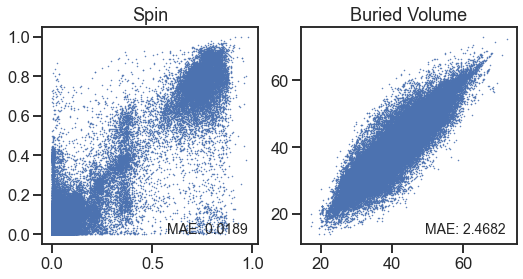

In [24]:
redf_pivot_spins = redf.pivot(index='smiles', columns='atom_index', values='fractional_spin')
redf_pivot_spins = redf_pivot_spins.reindex(redf_smiles)

redf_pivot_bur_vol = redf.pivot(index='smiles', columns='atom_index', values='bur_vol')
redf_pivot_bur_vol = redf_pivot_bur_vol.reindex(redf_smiles)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5,4))
axs[0].plot(redf_pivot_spins.values.flatten(), rpredicted_fractional_spins.numpy().flatten(), '.', ms=1)
axs[0].text(.95, .05, f'MAE: {pd.Series(redf_pivot_spins.values.flatten() - rpredicted_fractional_spins.numpy().flatten()).dropna().abs().mean():.4f}', ha='right',
            transform=axs[0].transAxes, fontsize=14)

axs[1].plot(redf_pivot_bur_vol.values.flatten(), rpredicted_bur_vol.flatten(), '.', ms=1)
axs[1].text(.95, .05, f'MAE: {pd.Series(redf_pivot_bur_vol.values.flatten() - rpredicted_bur_vol.flatten()).dropna().abs().mean():.4f}', ha='right',
            transform=axs[1].transAxes, fontsize=14)

axs[0].set_title('Spin')
axs[1].set_title('Buried Volume')

In [190]:
from preprocess_inputs import preprocessor
preprocessor.from_json('tfrecords/preprocessor.json')

from loss import AtomInfMask, KLWithLogits
from nfp import EdgeUpdate, NodeUpdate, GlobalUpdate

redox_model = tf.keras.models.load_model(
    '20200903_xfer_h2o_noinit/best_model.hdf5',
    custom_objects={**nfp.custom_objects,
                    **{'AtomInfMask': AtomInfMask, 'KLWithLogits': KLWithLogits,
                       'EdgeUpdate': EdgeUpdate,
                       'NodeUpdate': NodeUpdate,
                       'GlobalUpdate': GlobalUpdate}})

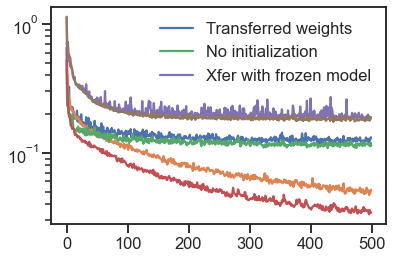

In [191]:
log = pd.read_csv('20200903_xfer_h2o/log.csv').set_index('epoch')
plt.semilogy(log['val_redox_loss'], label='Transferred weights')
plt.semilogy(log['redox_loss'])

log = pd.read_csv('20200903_xfer_h2o_noinit/log.csv').set_index('epoch')
plt.semilogy(log['val_redox_loss'], label='No initialization')
plt.semilogy(log['redox_loss'])

log = pd.read_csv('20200903_xfer_h2o_frozen/log.csv').set_index('epoch')
plt.semilogy(log['val_redox_loss'], label='Xfer with frozen model')
plt.semilogy(log['redox_loss'])

plt.legend()

In [196]:
_, _, redox_predictions = redox_model.predict(redf_dataset, verbose=1)

     54/Unknown - 5s 100ms/step

RDKit WARNING: [08:16:31] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [08:16:31]   BondStereo set to STEREONONE and single bond directions set to NONE.


    106/Unknown - 11s 103ms/step

RDKit WARNING: [08:16:36] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [08:16:36]   BondStereo set to STEREONONE and single bond directions set to NONE.


115/115 [==============================] - 12s 102ms/step


In [197]:
# Load redox properties
redf_redox = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/redf_redox.csv.gz')
redf_redox = redf_redox.set_index('smiles').reindex(redf_smiles)    

In [207]:
redf_redox['electron affinity'] - redox_predictions[:, 1]

smiles
[CH2]C1=COCC1                -0.003478
CC[C@H](C)C[CH]CCO                 NaN
CS[C@H]1CC[C@@H]1NC1[CH]C1   -0.010194
COC(C)[O]                     0.074414
[CH2]CCCCOC/C=C/C             0.011201
                                ...   
C=CC[CH]C=C(C)C               0.012905
[CH2][C@@H]1CCC[C@@H](C)C1   -0.049402
C=CO[C@H](C)[C](C)C           0.019942
[CH2][C@@H]1CCC[C@H](O)C1     0.028653
CO[C](C)C(C)C                -0.026339
Name: electron affinity, Length: 14599, dtype: float64

In [212]:
redf_redox['ie_pred'] = redox_predictions[:, 0]
redf_redox['ea_pred'] = redox_predictions[:, 1]

In [222]:
redf_valid = np.load('redf_split.npz', allow_pickle=True)['valid']

In [225]:
redox_test = redf_redox.reindex(np.concatenate([redf_test, redf_valid]))

Text(0.95, 0.05, 'MAE: 0.086')

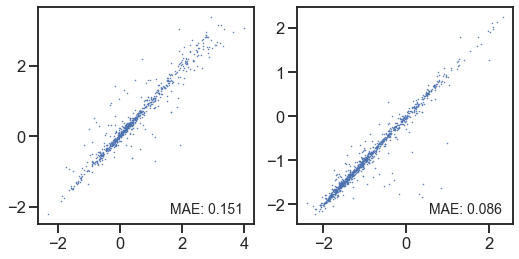

In [226]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5,4))
axs[0].plot(redox_test['ionization energy'], redox_test['ie_pred'], '.', ms=1)
axs[1].plot(redox_test['electron affinity'], redox_test['ea_pred'], '.', ms=1)

axs[0].text(.95, .05, f"MAE: {(redox_test['ionization energy'] - redox_test['ie_pred']).dropna().abs().mean():.3f}", ha='right',
            transform=axs[0].transAxes, fontsize=14)
axs[1].text(.95, .05, f"MAE: {(redox_test['electron affinity'] - redox_test['ea_pred']).dropna().abs().mean():.3f}", ha='right',
            transform=axs[1].transAxes, fontsize=14)

smiles
CC1=C[C@@H]([O])CCC1        0.020871
[CH2][C@H](O)C(=O)C1CC1          NaN
Cc1ccc([C]=O)c(O)c1         0.017444
[CH2]C=C=O                  0.022601
CC/C=[C]\C[C@@H]1CO1        0.011629
                              ...   
C=C(CCC)CC[O]               0.002524
[CH2]C(C)(C)OC[C@H](O)CO         NaN
[NH]NN=O                         NaN
[CH]=C[C@H](C)[C@H](C)CO         NaN
C[C](O)C[C@@H]1CO1          0.093270
Length: 1000, dtype: float64

Text(0, 0.5, 'Electron affinity error')

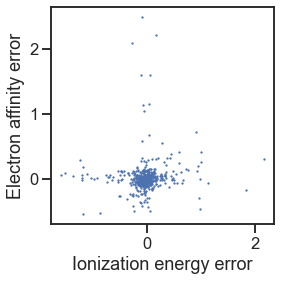

In [237]:
plt.figure(figsize=(4,4))
plt.plot((redox_test['ionization energy'] - redox_test['ie_pred']), 
         (redox_test['electron affinity'] - redox_test['ea_pred']), '.', ms=2.5)
plt.xlabel('Ionization energy error')
plt.ylabel('Electron affinity error')

In [241]:
(redox_test['ionization energy'] - redox_test['ie_pred']).abs().sort_values(ascending=False)

smiles
[CH2]C(=O)[C@H](C)SCCCO          2.163346
CS[C@H](C)C(=O)[N]C1CC1          1.828163
[CH2]S(=O)(=O)[C@@H](C)C(C)=O    1.578810
C[N+](C)(C)CCSC(=[N])N           1.504772
C=[C]CC(C(=O)O)C(=O)O            1.363854
                                   ...   
[CH2]C(=O)CCC[C@@H](O)CC              NaN
C/C(=N/O)C1[CH]C1                     NaN
[CH2]C(C)(C)OC[C@H](O)CO              NaN
[NH]NN=O                              NaN
[CH]=C[C@H](C)[C@H](C)CO              NaN
Length: 1000, dtype: float64

In [242]:
(redox_test['electron affinity'] - redox_test['ea_pred']).abs().sort_values(ascending=False)

smiles
C=C(C[CH]CC)OC=O               2.491680
O=C1CCC[CH]CC[C@@H]1O          2.217799
CCC(=O)OCC[CH]O                2.087794
[CH2]CC1CC(=O)CC(=O)C1         1.936857
[CH2]C(/C=C/[N+](=O)[O-])CC    1.602477
                                 ...   
CC(=O)O[C@@H]1[CH]OCCO1             NaN
CCC[C@@H](C)S[C@H](C)[CH]O          NaN
[CH2][C@@H](CCO)SCCSC               NaN
COC[C@H](C)NC[CH]CS                 NaN
[C]1=CO1                            NaN
Length: 1000, dtype: float64

## Drawing outliers

In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from IPython.display import SVG
from collections import defaultdict

pred_spin_df = cdf_test_merged.set_index(['smiles', 'atom_index'])

def draw(smiles, thres=0.25):

    mol = rdkit.Chem.MolFromSmiles(smiles)

    atomHighlights = defaultdict(list)

    colors = {'DFT':(1,0,0),
              'ML':(0,0,1),
              'rad':(0,1,0)
             }

    for atom in mol.GetAtoms():

        row = pred_spin_df.loc[smiles, atom.GetIdx()]
        if row.fractional_spin > thres:
            atomHighlights[atom.GetIdx()].append(colors['DFT'])

        if row.predicted_fractional_spin > thres:
            atomHighlights[atom.GetIdx()].append(colors['ML'])       

        if atom.GetNumRadicalElectrons() > 0:
            atomHighlights[atom.GetIdx()].append(colors['rad'])       


    d2d = rdMolDraw2D.MolDraw2DSVG(600,280,300,280)
    dos = d2d.drawOptions()
    dos.atomHighlightsAreCircles = True
    dos.fillHighlights=False

    d2d.DrawMoleculeWithHighlights(mol,smiles,dict(atomHighlights),{},{},{})
    d2d.FinishDrawing()
    return SVG(d2d.GetDrawingText())

In [ ]:
cdf_test_merged.sort_values('abs_err', ascending=False).drop_duplicates(subset='smiles', keep='first').head(10)

* Red: DFT
* Blue: ML
* Green: Formal radical center

In [ ]:
draw('Cc1nc(CC([O])=O)co1')

In [ ]:
draw('[O]C(=O)C[C@@H]1CO1')

Looks like there's some problem with carboxylic acid radicals. Let's pull all of them to see how we do on average

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
patt = Chem.MolFromSmarts('[OX1v1+0]C(=O)')  # https://www.daylight.com/dayhtml_tutorials/languages/smarts/smarts_examples.html#RAD
unique_mols = pd.Series(cdf_test.smiles.unique())
is_carboxylic_acid = unique_mols.progress_apply(lambda x: Chem.MolFromSmiles(x).HasSubstructMatch(patt))

In [ ]:
matches = unique_mols[is_carboxylic_acid].progress_apply(lambda x: pd.Series(Chem.MolFromSmiles(x).GetSubstructMatch(patt)))
matches['smiles'] = unique_mols[is_carboxylic_acid]
matches = matches.melt(id_vars='smiles')[['smiles', 'value']].rename(columns={'value': 'atom_index'})
df = matches.merge(cdf_test_merged, on=['smiles', 'atom_index'])
odf = df[df.atom_type == 'O']

In [ ]:
len(unique_mols[is_carboxylic_acid])

In [ ]:
odf.fractional_spin.plot.hist()

In [ ]:
importsmilessycopg2

dbparams = {
    'dbname': 'bde',
    'port': 5432,
    'host': 'yuma.hpc.nrel.gov',
    'user': 'bdeops',
    'password': 'BD30ps99!',
    'options': f'-c search_path=bde',
}

with psycopg2.connect(**dbparams) as conn:

    logdf = pd.read_sql_query("""
    SELECT * from unique_compound 
    where type='fragment' and status='finished'
    """, conn)
    

In [ ]:
cooh_logs = logdf[logdf.smiles.isin(unique_mols[is_carboxylic_acid])]

In [ ]:
import shutil

In [ ]:
import os

In [ ]:
for log in cooh_logs.logfile:
    shutil.copy(log, os.path.join('coo_logs', os.path.basename(log)))

In [ ]:
matches.melt()['value']

In [ ]:
cdf_subset = cdf_test_merged[cdf_test_merged.smiles.isin(unique_mols[is_carboxylic_acid])]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(cdf_subset.fractional_spin, cdf_subset.predicted_fractional_spin, '.', ms=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=10)
ax.set_xlabel('Measured fractional spin')
ax.set_ylabel('Predicted fractional spin')
ax.set_title('Just [O]C(=O) Radicals')

Yup; not great here

In [ ]:
cdf_subset[cdf_subset.fractional_spin > .5].head(10)

Sometimes it ends up on the formal radical center...

In [ ]:
draw('C[C@]1(CC([O])=O)C[C@@]1(F)Cl')

In [ ]:
draw('C=CCCC(=C)C([O])=O')

In [ ]:
draw('CCC[C@H]1C[C@@H]1C([O])=O')

In [ ]:
formal_center = unique_mols.progress_apply(lambda x: [atom.GetIdx() for atom in Chem.MolFromSmiles(x).GetAtoms() if (atom.GetNumRadicalElectrons() == 1)][0])

In [ ]:
formal_center.name = 'atom_index'
radical_center_df = pd.DataFrame(formal_center)
radical_center_df['smiles'] = unique_mols

In [ ]:
preds_on_formal_center = radical_center_df.merge(cdf_test_merged, on=['smiles', 'atom_index'], how='left')

In [ ]:
cdf_subset = cdf_test_merged[cdf_test_merged.smiles.isin(unique_mols[is_carboxylic_acid])]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(preds_on_formal_center.fractional_spin, preds_on_formal_center.predicted_fractional_spin, '.', ms=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=10)
ax.set_xlabel('Measured fractional spin')
ax.set_ylabel('Predicted fractional spin')
ax.set_title('Predictions on the formal radical center')

In [ ]:
# what about non carboxylic acid errors
cdf_test_merged[~cdf_test_merged.smiles.isin(unique_mols[is_carboxylic_acid])].sort_values(
    'abs_err', ascending=False).drop_duplicates(subset='smiles', keep='first').head(10)

This is a neat one

In [ ]:
draw('O=c1cnc2[c][nH]ccn1-2', thres=0.15)

What about what we're interested in, spin-delocalized radicals

In [ ]:
max_spin_by_mol = cdf_test_merged.groupby('smiles').fractional_spin.max()
max_spin_by_mol.plot.hist()

In [ ]:
delocalized = cdf_test_merged[cdf_test_merged.smiles.isin(max_spin_by_mol[max_spin_by_mol < 0.5].index)]

cdf_subset = cdf_test_merged[cdf_test_merged.smiles.isin(unique_mols[is_carboxylic_acid])]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(delocalized.fractional_spin, delocalized.predicted_fractional_spin, '.', ms=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=10)
ax.set_xlabel('Measured fractional spin')
ax.set_ylabel('Predicted fractional spin')
ax.set_title('Predictions on spin-delocalized radicals')

well, that's reassuring. Looks like we do decently here

In [ ]:
delocalized = cdf_test_merged[cdf_test_merged.smiles.isin(max_spin_by_mol[max_spin_by_mol < 0.25].index)]

cdf_subset = cdf_test_merged[cdf_test_merged.smiles.isin(unique_mols[is_carboxylic_acid])]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(delocalized.fractional_spin, delocalized.predicted_fractional_spin, '.', ms=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=10)
ax.set_xlabel('Measured fractional spin')
ax.set_ylabel('Predicted fractional spin')
ax.set_title('Predictions on super-delocalized radicals')

In [ ]:
patt = Chem.MolFromSmarts('[OX1v1+0]C=C')  # https://www.daylight.com/dayhtml_tutorials/languages/smarts/smarts_examples.html#RAD
unique_mols = pd.Series(cdf_test.smiles.unique())
robs_radical1 = unique_mols.progress_apply(lambda x: Chem.MolFromSmiles(x).HasSubstructMatch(patt))

patt = Chem.MolFromSmarts('[CX3v3+0]C=O')  # https://www.daylight.com/dayhtml_tutorials/languages/smarts/smarts_examples.html#RAD
robs_radical2 = unique_mols.progress_apply(lambda x: Chem.MolFromSmiles(x).HasSubstructMatch(patt))

In [ ]:
unique_mols[robs_radical2]

In [ ]:
draw('CC1=NC=C([O])C=CC1', thres=0.15)

In [ ]:
draw('C=C(C)[C@H](O)C(=C)[O]', thres=0.15)

In [ ]:
draw('C[C@@]12CCCC[C]1C(=O)C2', thres=0.15)

In [ ]:
len(unique_mols[robs_radical1 | robs_radical2])

In [ ]:
cdf_subset = cdf_test_merged[cdf_test_merged.smiles.isin(unique_mols[robs_radical1 | robs_radical2])]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(cdf_subset.fractional_spin, cdf_subset.predicted_fractional_spin, '.', ms=1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(trim=True, offset=10)
ax.set_xlabel('Measured fractional spin')
ax.set_ylabel('Predicted fractional spin')

In [ ]:
patt = Chem.MolFromSmarts('[OX1v1+0]C=C')
matches = unique_mols[robs_radical1].progress_apply(lambda x: pd.Series(Chem.MolFromSmiles(x).GetSubstructMatch(patt)))
matches['smiles'] = unique_mols[robs_radical1]

patt2 = Chem.MolFromSmarts('[CX3v3+0]C=O')
matches2 = unique_mols[robs_radical2].progress_apply(lambda x: pd.Series(Chem.MolFromSmiles(x).GetSubstructMatch(patt2)))
matches2['smiles'] = unique_mols[robs_radical2]

matches = matches.append(matches2)

matches = matches.drop(1, axis=1).melt(id_vars='smiles')[['smiles', 'value']].rename(columns={'value': 'atom_index'})
df = matches.merge(cdf_test_merged, on=['smiles', 'atom_index'])

In [ ]:
df[df.atom_type == 'O'].spin.plot.hist(range=(0,1), label='O')
df[df.atom_type == 'C'].spin.plot.hist(range=(0,1), label='C')
plt.legend(loc='upper center')